**Inference Pipeline**
---
**Important notes, and requirements**
*   Make sure the enviroment is running on google colab.
*   Download the best_model.pt file from github, and upload it directly onto the local folder in colab runtime, hence the final path of the model being /content/best_model.pt
* Change the URL  at twitch_url, by copy pasting the link of the twitch VOD you want to generate highlights for and pasting the link inside the double quotes
* This pipeline uses Demucs, an audio seperation tool, which requires a decent GPU- cuda V12.5.8, the tested inference was done using T4 gpu of colab
* The amount of clips, can be configured by changing top_n paramater in the config file
* The current threshold, is configured as to take the top 1 percentile sliding window, it is recommended to run the code till visualization, which lists the probablity vs time distribution, and configuring the threshold there only, then running the remaining steps.
* The sliding window is set to 30 seconds, which will produce clips of that length only, to change, you can modify window_sec paramater, but MAKE SURE it is below 60 seconds
* The checkpoint directory, contained within the base path- contains the necesary intermediate files, including the raw audio, seperated audio in "chunks", log mel spectrogram, and raw predictions for all the sliding windows as well as the metadata for the final clips

**1. Installing additional dependencies, other than what colab already has**






In [1]:
!pip install -q yt-dlp demucs librosa tqdm torchcodec

print("Dependencies installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.9 MB/s eta 0:00:00
Dependencies installed!


**2. Setting up Base path, currently it is set at the local storage of colab runtime, you can change accordingly**

In [2]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
BASE_PATH = '/content'

**3. Configuration**

In [3]:
import os
from dataclasses import dataclass, field

@dataclass
class Config:
    # main inputs
    twitch_url: str = "https://www.twitch.tv/videos/2657723379"
    model_path: str = "/content/best_model.pt"

    # output folders
    output_dir: str = os.path.join(BASE_PATH, "HighlightOutput_inference")
    checkpoint_dir: str = os.path.join(BASE_PATH, "HighlightOutput_inference", "checkpoints")

    # audio settings
    sample_rate: int = 22050
    n_mels: int = 80
    hop_length: int = 512

    # inference settings
    window_sec: float = 30.0
    stride_sec: float = 5.0
    threshold_percentile: float = 99 # in percentage
    nms_window: float = 10.0
    top_n: int = 20

    # model settings
    cnn_channels = [32, 64, 128, 256]
    rnn_hidden: int = 256
    rnn_layers: int = 2
    rnn_dropout: float = 0.3
    attention_dim: int = 128
    dropout: float = 0.5

    def __post_init__(self):
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    @property
    def window_frames(self):
        return int((self.window_sec * self.sample_rate) / self.hop_length) + 1

    @property
    def stride_frames(self):
        return int((self.stride_sec * self.sample_rate) / self.hop_length)


cfg = Config()

print("Config Loaded")
print("VOD URL:", cfg.twitch_url)
print("Model Path:", cfg.model_path)
print("Output Folder:", cfg.output_dir)
print("Checkpoints Folder:", cfg.checkpoint_dir)
print("Window Seconds:", cfg.window_sec, "Frames:", cfg.window_frames)
print("Stride Seconds:", cfg.stride_sec, "Frames:", cfg.stride_frames)
print("Threshold:", cfg.threshold_percentile)

Config Loaded
VOD URL: https://www.twitch.tv/videos/2657723379
Model Path: /content/best_model.pt
Output Folder: /content/HighlightOutput_inference
Checkpoints Folder: /content/HighlightOutput_inference/checkpoints
Window Seconds: 30.0 Frames: 1292
Stride Seconds: 5.0 Frames: 215
Threshold: 99


**4. Downloading audio file** using ffmpeg to download the audio and saving it in the checkpoint directory, as vod_audio.m4a

In [5]:
import os

print("Step 3: Downloading Audio")

audio_path = os.path.join(cfg.checkpoint_dir, "vod_audio.m4a")

# Check if already downloaded
if os.path.exists(audio_path):
    print("Audio already exists:", audio_path)
else:
    print("Downloading audio...")
    !yt-dlp -f "Audio_Only" -o "{audio_path}" "{cfg.twitch_url}"
print("Step 3 done")


Step 3: Downloading VOD
Audio already exists: /content/drive/MyDrive/HighlightOutput_inference/checkpoints/vod_audio.m4a
Video already exists: /content/drive/MyDrive/HighlightOutput_inference/checkpoints/vod_video.mp4
Step 3 done


**5. Running seperation through demucs**- this part divides the long VOD to minute long chunks for processing by demucs, after which they are patched together and saved in the checkpoint directory folder as vocals.wav and game.wav

In [6]:
import os
import subprocess
import torch

print("Chunked Audio Separation")

audio_path = os.path.join(cfg.checkpoint_dir, "vod_audio.m4a")
vocals_path = os.path.join(cfg.checkpoint_dir, "vocals.wav")
game_path = os.path.join(cfg.checkpoint_dir, "game.wav")

# skip if already processed
if os.path.exists(vocals_path) and os.path.exists(game_path):
    print("Already separated. Skipping.")
    print("Vocals:", vocals_path)
    print("Game:", game_path)

else:
    if not os.path.exists(audio_path):
        raise RuntimeError("Audio file not found.")

    device = "cuda" if torch.cuda.is_available() else "cpu"

    chunks_dir = os.path.join(cfg.checkpoint_dir, "chunks_temp")
    out_dir = os.path.join(cfg.checkpoint_dir, "demucs_temp")

    os.makedirs(chunks_dir, exist_ok=True)
    os.makedirs(out_dir, exist_ok=True)

    # split audio into 60s chunks
    print("Splitting audio into chunks...")
    chunk_pattern = os.path.join(chunks_dir, "chunk_%03d.wav")

    subprocess.run([
    "ffmpeg", "-y",
    "-i", audio_path,
    "-f", "segment",
    "-segment_time", "60",
    "-acodec", "pcm_s16le",
    "-ar", "44100",
    "-ac", "2",
    chunk_pattern
    ], check=True)

    chunk_files = sorted([os.path.join(chunks_dir, f) for f in os.listdir(chunks_dir)])

    if len(chunk_files) == 0:
        raise RuntimeError("No chunks created.")

    print("Running Demucs on chunks...")
    for i,chunk in enumerate(chunk_files):
      print(f"running demucs on {i}th chunk")
      subprocess.run([
            "python", "-m", "demucs",
            "--two-stems", "vocals",
            "-n", "htdemucs",
            "-d", device,
            "--jobs", "1",
            "-o", out_dir,
            chunk
        ])

    # collect separated files
    vocals_list = []
    game_list = []

    for chunk in chunk_files:
        name = os.path.splitext(os.path.basename(chunk))[0]
        folder = os.path.join(out_dir, "htdemucs", name)

        v = os.path.join(folder, "vocals.wav")
        g = os.path.join(folder, "no_vocals.wav")

        if os.path.exists(v) and os.path.exists(g):
            vocals_list.append(v)
            game_list.append(g)

    if len(vocals_list) == 0 or len(game_list) == 0:
        raise RuntimeError("Demucs outputs missing.")

    # helper to merge
    def merge(files, out_file):
        txt = os.path.join(cfg.checkpoint_dir, "list.txt")
        with open(txt, "w") as f:
            for x in files:
                f.write(f"file '{x}'\n")

        subprocess.run([
            "ffmpeg", "-y",
            "-f", "concat",
            "-safe", "0",
            "-i", txt,
            "-c", "copy",
            out_file
        ])

    print("Merging vocals...")
    merge(vocals_list, vocals_path)

    print("Merging game audio..")
    merge(game_list, game_path)

    print("Vocals:", vocals_path)
    print("Game:", game_path)


Step 4: Chunked Audio Separation
Already separated. Skipping.
Vocals: /content/drive/MyDrive/HighlightOutput_inference/checkpoints/vocals.wav
Game: /content/drive/MyDrive/HighlightOutput_inference/checkpoints/game.wav
Step 4 complete


**6. Converting to log mel spectrograms and stacking**  This converts the raw vocals and game wav files to stacked pytorch tensors, saved as spectrogram.pt in the checkpoint directory

In [4]:
%%time
import torch
import numpy as np
import librosa
import os


SPEC_CHECKPOINT = os.path.join(cfg.checkpoint_dir, "spectrogram.pt")
vocals_path = os.path.join(cfg.checkpoint_dir, "vocals.wav")
game_path = os.path.join(cfg.checkpoint_dir, "game.wav")


# If already created, load it
if os.path.exists(SPEC_CHECKPOINT):
    print("Found saved spectrogram.")
    spectrogram = torch.load(SPEC_CHECKPOINT)

    frames = spectrogram.shape[2]
    duration_sec = frames * cfg.hop_length / cfg.sample_rate

    print("Loaded successfully")
    print("Duration (minutes):", duration_sec / 60)

else:
  # function to convert to log mel spectrograms
    def audio_to_melspec(path, sr, n_mels, hop_length, label):
        print(f"Processing {label}")
        y, _ = librosa.load(path, sr=sr, mono=True)

        print("Audio length (seconds):", len(y) / sr)

        mel = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_mels=n_mels,
            hop_length=hop_length
        )

        mel = librosa.power_to_db(mel, ref=np.max)

        print("Mel shape:", mel.shape)
        return mel

    # Create mel specs
    vocals_mel = audio_to_melspec(
        vocals_path,
        cfg.sample_rate,
        cfg.n_mels,
        cfg.hop_length,
        "vocals"
    )

    game_mel = audio_to_melspec(
        game_path,
        cfg.sample_rate,
        cfg.n_mels,
        cfg.hop_length,
        "game audio"
    )

    # Match lengths
    length = min(vocals_mel.shape[1], game_mel.shape[1])
    vocals_mel = vocals_mel[:, :length]
    game_mel = game_mel[:, :length]

    # Stack- final shape (2, n_mels, frames)
    spectrogram = np.stack([vocals_mel, game_mel], axis=0)
    spectrogram = torch.from_numpy(spectrogram).float()

    # Save
    torch.save(spectrogram, SPEC_CHECKPOINT)

    duration_sec = length * cfg.hop_length / cfg.sample_rate

    print("Saved spectrogram")
    print("Path:", SPEC_CHECKPOINT)
    print("Shape:", spectrogram.shape)


Step 5: Creating Mel Spectrograms
Found saved spectrogram.
Loaded successfully
Duration (minutes): 153.41888435374148
Step 5 completed
CPU times: user 1.37 s, sys: 460 ms, total: 1.83 s
Wall time: 19.6 s


**7. Loading the model** uses the trained HighlightSense Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#conv block
class ConvBlock(nn.Module):
    def __init__(self, inc, outc, pool=(2,2), first_layer=False):
        super().__init__()
        self.conv = nn.Conv2d(inc, outc, 3, padding=1)

        if first_layer:
            self.bn = nn.InstanceNorm2d(outc, affine=True)
        else:
            self.bn = nn.BatchNorm2d(outc)

        self.pool = nn.MaxPool2d(pool)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        return x


#attn layer define
class Attention(nn.Module):
    def __init__(self, dim, att_dim):
        super().__init__()
        self.W = nn.Linear(dim, att_dim)
        self.V = nn.Linear(att_dim, 1, bias=False)

    def forward(self, x, mask=None):
        e = torch.tanh(self.W(x))
        s = self.V(e).squeeze(-1)

        if mask is not None:
            s = s.masked_fill(mask == 0, float("-inf"))

        w = F.softmax(s, dim=1)
        ctx = torch.bmm(w.unsqueeze(1), x).squeeze(1)
        return ctx, w



# Main Model
class HighlightSenseModel(nn.Module):
    def __init__(
        self,
        n_mels=80,
        cnn_channels=[32,64,128,256],
        rnn_hidden=256,
        rnn_layers=2,
        rnn_dropout=0.3,
        att_dim=128,
        dropout=0.5
    ):
        super().__init__()

        layers = []
        in_ch = 2

        # CNN
        for i, out_ch in enumerate(cnn_channels):
            pool = (2,2) if i < 3 else (1,2)
            first = (i == 0)
            layers.append(ConvBlock(in_ch, out_ch, pool, first_layer=first))
            in_ch = out_ch

        self.cnn = nn.Sequential(*layers)

        freq_out = n_mels // 8
        rnn_input = cnn_channels[-1] * freq_out

        # RNN
        self.rnn = nn.GRU(
            input_size=rnn_input,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            batch_first=True,
            bidirectional=True,
            dropout=rnn_dropout if rnn_layers > 1 else 0
        )

     #attention+classifier
        self.attention = Attention(rnn_hidden * 2, att_dim)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(rnn_hidden * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(128, 1)
        )

    def forward(self, x, mask=None):
        B = x.size(0)

        c = self.cnn(x)
        c = c.permute(0, 3, 1, 2)
        c = c.reshape(B, c.size(1), -1)

        if mask is not None:
            m = mask[:, ::16]
            m = m[:, :c.size(1)]
        else:
            m = None

        r, _ = self.rnn(c)
        ctx, att = self.attention(r, m)
        out = self.classifier(ctx)

        return out, att


# Create Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = HighlightSenseModel(
    n_mels=cfg.n_mels,
    cnn_channels=cfg.cnn_channels,
    rnn_hidden=cfg.rnn_hidden,
    rnn_layers=cfg.rnn_layers,
    rnn_dropout=cfg.rnn_dropout,
    att_dim=cfg.attention_dim,
    dropout=cfg.dropout
).to(device)
#loading weights
print(f"Loading weights from: {cfg.model_path}")

checkpoint = torch.load(cfg.model_path, map_location=device,weights_only=False)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

print("Model weights loaded successfully!")


Device: cuda
Loading weights from: /content/best_model.pt
Model weights loaded successfully!


**8. Sliding window** This runs the sliding window, through the vod and then pads the clips to 60 seconds, using pad_value as the lowest energy time step derived from the raw clip, as to match the training setup. raw_window_scores is the csv file containing the index, starting time step, ending time step and the model confidence out of 1

In [8]:
import torch
import torch.nn.functional as F
import csv
import os

output_csv = os.path.join(cfg.checkpoint_dir, "raw_window_scores.csv")
results=[]
raw_results=[]

print("Window seconds:", cfg.window_sec)
print("Stride seconds:", cfg.stride_sec)
print("Threshold percentile:", cfg.threshold_percentile)

total_frames = spectrogram.shape[2]
window_frames = cfg.window_frames
stride_frames = cfg.stride_frames
# all clips padded to target frames that is 60 seconds
target_frames = int((60 * cfg.sample_rate) / cfg.hop_length)
num_windows = max(1, (total_frames - window_frames) // stride_frames + 1)
print("Total windows:", num_windows)

results = []

model.eval()
with torch.no_grad():
    for i in range(num_windows):
        start_frame = i * stride_frames
        end_frame = start_frame + window_frames

        if end_frame > total_frames:
            end_frame = total_frames
            start_frame = max(0, end_frame - window_frames)
#padding to 60 second window size 30 to match training input
        window = spectrogram[:, :, start_frame:end_frame]
        actual_frames = window.shape[2]
        pad_needed = target_frames - actual_frames
        if pad_needed > 0:
          pad_value = window.min().item()
          window = F.pad(window, (0, pad_needed), value=pad_value)

# Mask
        mask = torch.zeros(target_frames)
        mask[:actual_frames] = 1
        window = window.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        logits, _ = model(window, mask)
        prob = torch.sigmoid(logits).item()
        start_sec = start_frame * cfg.hop_length / cfg.sample_rate
        end_sec = end_frame * cfg.hop_length / cfg.sample_rate
        raw_results.append([i,start_sec,end_sec,prob])

print("Writing CSV:", output_csv)
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["window_index", "start_sec", "end_sec", "confidence"])
    writer.writerows(raw_results)

print("Total windows scored:", len(raw_results))


Window seconds: 30.0
Stride seconds: 5.0
Threshold percentile: 99


NameError: name 'spectrogram' is not defined

**9. Visualisation and modification** the first part in this section, first run the 1st part and 2nd part, check the graph plotted, the dotted red line represents the threshold probablity, any sliding window having probablity below that percentile wont be considered, lower the the percentile to have higher amount of clips, but having lower confidence score, and higher to filter out only the top clips, to change the percentile from here only, uncomment the threshold_percentile, and change it to your preference

In [34]:
threshold_percentile=cfg.threshold_percentile
#---------------------------------------------------------------------------------------------------------------
# CURRENTLY THRESHOLD PERCENTILE IS SET AT 99, uncomment below to change it according to the visualisation below
# threshold_percentile=99.9
#---------------------------------------------------------------------------------------------------------------
probablity_calc = [row[3] for row in raw_results]
new_threshold=np.percentile(probablity_calc,threshold_percentile)
for row in raw_results:
  r_idx = row[0]
  r_start = row[1]
  r_end = row[2]
  r_prob = row[3]
  if r_prob >= new_threshold:
   results.append([r_idx,r_start,r_end,r_prob])
print("Windows above threshold:", len(results))

Windows above threshold: 32
Step 7 Completed


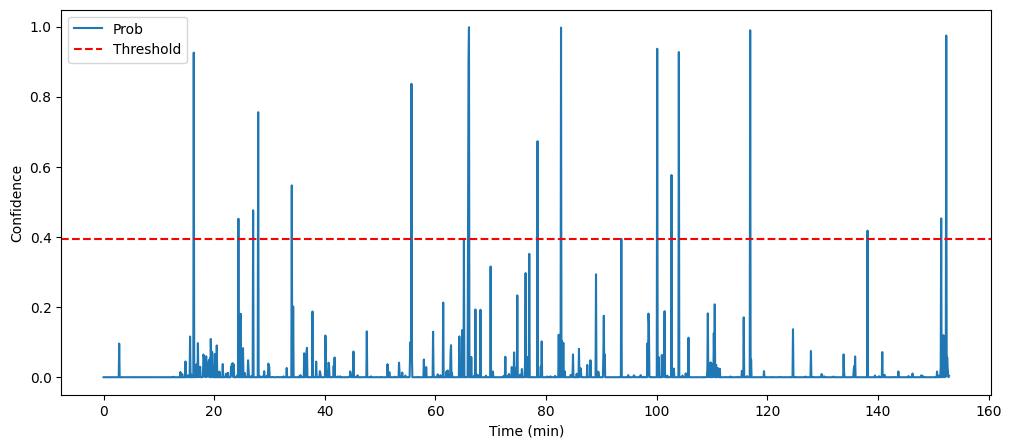

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# reading raw csv
csv_path = os.path.join(cfg.checkpoint_dir, "raw_window_scores.csv")
df = pd.read_csv(csv_path)

# plot time (x) vs confidence (y)
plt.figure(figsize=(12, 5))
plt.plot(df['start_sec'] / 60, df['confidence'], label='Prob')
plt.axhline(y=new_threshold, color='red', linestyle='--', label='Threshold')

plt.xlabel('Time (min)')
plt.ylabel('Confidence')
plt.legend()
plt.show()

**10. Running NMS Supression** running the NMS script on the clips above the threshold, and discarding similar clips, which have a high intersection, keeping only 1 copy.

In [9]:
import csv
import os

def apply_nms(detections, nms_window):
    if not detections:
        return []

    # sort by confidence (highest first)
    detections = sorted(detections, key=lambda x: x[3], reverse=True)
    kept = []
    removed = set()

    for i, det in enumerate(detections):
        if i in removed:
            continue

        kept.append(det)

        for j, other in enumerate(detections[i+1:], start=i+1):
            if j in removed:
                continue

            # time values
            det_start = det[1]
            det_end = det[2]

            other_start = other[1]
            other_end = other[2]

            # overlap check
            overlap_start = max(det_start, other_start)
            overlap_end = min(det_end, other_end)
            overlaps = overlap_end > overlap_start

            # also treat "very close" clips as duplicates
            close_start = abs(det_start - other_start) < nms_window

            if overlaps or close_start:
                removed.add(j)

    # sort by start time for clean output
    return sorted(kept, key=lambda x: x[1])


def to_timestamp(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = int(sec % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"


print("NMS window:", cfg.nms_window)
final_detections = apply_nms(results, cfg.nms_window)

print("After NMS:", len(results), "to", len(final_detections))

if not final_detections:
    print("No highlights found")

else:
    # sort again by confidence and take top N
    top = sorted(final_detections, key=lambda x: x[3], reverse=True)[:cfg.top_n]

    print("\nTop detections:")
    print("Rank | Start | End | Duration | Confidence")

    for i, det in enumerate(top):
        start = to_timestamp(det[1])
        end = to_timestamp(det[2])
        duration = det[2] - det[1]
        print(i+1, start, end, f"{duration:.1f}s", f"{det[3]:.3f}")

        for i, det in enumerate(top):
            writer.writerow([
                i+1,
                det[1],
                det[2],
                to_timestamp(det[1]),
                to_timestamp(det[2]),
                det[2] - det[1],
                det[3]
            ])
print("Step 8 complete")


NMS window: 10.0
After NMS: 0 to 0
No highlights found
Step 8 complete


**11. Extracting video clips** extracting the clips, directly from the source using FFMPEG, the final clip metadata is saved as meta_csv in the checkpoint folder, containing metadata about the clip path, duration, confidence score, and time stamps. The clips are stored as highlight_0i.mp4 in the clips directory in base folder

In [41]:
import os
import csv
import subprocess

print("Step 9: Extracting Video Clips")

CLIPS_DIR = os.path.join(cfg.output_dir, "clips")
os.makedirs(CLIPS_DIR, exist_ok=True)

print("Getting Twitch stream URL...")
stream_url = subprocess.check_output([
    "yt-dlp", "-g", "-f", "best", cfg.twitch_url
]).decode().strip()

def to_timestamp(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = int(sec % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

TOP_N = min(cfg.top_n, len(final_detections))
print("Extracting top", TOP_N, "clips")
print("Saving clips to:", CLIPS_DIR)

top = sorted(final_detections, key=lambda x: x[3], reverse=True)[:TOP_N]

clip_info = []

for i, det in enumerate(top):
    start_sec = max(0, det[1])
    end_sec = det[2]
    duration = end_sec - det[1]

    clip_path = os.path.join(CLIPS_DIR, f"highlight_{i+1:02d}.mp4")

    print("Clip", i+1, "start:", to_timestamp(start_sec), "duration:", round(duration))

    subprocess.run([
        "ffmpeg", "-y", "-hide_banner", "-loglevel", "error",
        "-ss", str(start_sec),
        "-i", stream_url,
        "-t", str(duration),
        "-c", "copy",
        clip_path
    ])

    clip_info.append([
        i+1,
        det[1],
        det[2],
        to_timestamp(det[1]),
        to_timestamp(det[2]),
        det[2] - det[1],
        det[3],
        clip_path
    ])

meta_csv = os.path.join(cfg.output_dir, "final_clips_metadata.csv")
with open(meta_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "rank", "start_sec", "end_sec",
        "start_ts", "end_ts",
        "duration_sec", "confidence", "clip_path"
    ])
    writer.writerows(clip_info)

print("Step 9 completed")


Step 9: Extracting Video Clips
Getting Twitch stream URL...
Extracting top 17 clips
Saving clips to: /content/drive/MyDrive/HighlightOutput_inference/clips
Clip 1 start: 01:06:03 duration: 30
Clip 2 start: 01:22:42 duration: 30
Clip 3 start: 01:56:54 duration: 30
Clip 4 start: 02:32:20 duration: 30
Clip 5 start: 01:40:05 duration: 30
Clip 6 start: 01:44:00 duration: 30
Clip 7 start: 00:16:18 duration: 30
Clip 8 start: 00:55:39 duration: 30
Clip 9 start: 00:27:57 duration: 30
Clip 10 start: 01:18:27 duration: 30
Clip 11 start: 01:42:40 duration: 30
Clip 12 start: 00:34:01 duration: 30
Clip 13 start: 00:27:02 duration: 30
Clip 14 start: 02:31:25 duration: 30
Clip 15 start: 00:24:22 duration: 30
Clip 16 start: 02:18:07 duration: 30
Clip 17 start: 01:33:36 duration: 30
Step 9 completed


**12. Cleanup** to run another vod, first uncomment out the below code, which cleans the output directory, and before running script from the start comment it again

In [ ]:
#import shutil; shutil.rmtree(cfg.output_dir, ignore_errors=True)